# **Part 2: Training and Testing the AI Model - Quantifying Bias in a Parkinson’s Disease Classification Website**

This notebook presents the second phase of our Parkinson’s Disease classification study, focusing on evaluating how well various AI models perform on the current dataset. The goal of this phase is not to assess fairness, but rather to examine the overall quality and suitability of the dataset for training robust machine learning models.

We apply several classification algorithms—including Logistic Regression, Decision Tree, Random Forest, Support Vector Machine, XGBoost, and LightGBM—to predict Parkinson’s Disease status based on structured user interaction data. Each model is evaluated using 5-fold cross-validation with bootstrapping to obtain stable estimates of model performance.

To further validate the generalization ability of the models, the top-performing classifiers are tested on a separate 30% held-out test set. The analysis includes key performance metrics such as F1 Score, AUROC, Sensitivity, and Specificity, providing insight into how well the current dataset supports accurate prediction of Parkinson’s Disease.

### **Import Necessary Modules**

In [47]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split, cross_validate, cross_val_predict, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, recall_score, roc_auc_score
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE, RandomOverSampler
from collections import Counter

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate

In [32]:
try:
    from google.colab import drive
    drive.mount('/content/drive/')
    %cd '/content/drive/MyDrive/Parkinson Paper/'
    COLAB = True
    project_url = './'
except:
    COLAB = False
    project_url = './'

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/MyDrive/Parkinson Paper


### **Load Dataset**

In [33]:
data = pd.read_csv(f'{project_url}/data/final/dataset.csv', index_col=None)
data["Parkinson's Disease status"] = data["Parkinson's Disease status"].replace('suspectedpd', 'pd')
data

,Parkinson's Disease status,Age,Gender,Race,M_deviation,A_tcl,A_tslww,P_isl,N_tislnt,A_tsw,...,mean_of_total_amount_of_time_taken_to_trace_lines_with_respect_to_window_width,mean_of_total_Number_of_points_to_traced_inside_line_with_no_regard_to_time_taken,Interaction_Time_Straight_False_Presses,Interaction_Time_Sine_Wave_False_presses,Interaction_Time_Spiral_False_presses,Number of correctly pressed keys when prompted with a constant key with respect to average response time,Number of correctly pressed keys when prompted with a semi-random key with respect to average response time,Ratio_Points_Sine_Straight,Ratio_Points_Spiral_Straight,Ratio_Points_Sine_Spiral
0,pd,61.0,Male,Native Hawaiian or Other Pacific Islander,0.023886,500,0.347222,1.000000,1,1000,...,0.810185,1.666667,0,0,0,0.021572,0.021427,0.500000,0.750000,0.666667
1,nonpd,58.0,Male,White,-0.000934,1500,1.169135,1.000000,3,3500,...,1.818654,4.000000,1500,3500,2000,0.002239,0.002906,0.857143,0.750000,1.142857
2,pd,67.0,Female,White,0.018477,10500,5.468750,1.000000,21,25000,...,8.420139,13.333333,0,0,0,0.001852,0.001481,0.200000,0.346154,0.577778
3,nonpd,61.0,Male,White,0.002205,1000,0.779423,1.000000,2,3500,...,1.688750,3.333333,0,0,0,0.002238,0.000563,0.714286,0.750000,0.952381
4,pd,62.0,Male,White,0.102513,3500,1.822917,0.285714,2,16500,...,4.687500,6.333333,21000,99000,42000,0.011312,0.012441,0.848485,2.250000,0.377104
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
261,pd,64.0,Male,Black or African American,0.005400,3000,2.196193,1.000000,6,15500,...,6.344558,17.000000,0,0,0,0.000795,0.009252,1.000000,0.933333,1.071429
262,NaN,NaN,NaN,NaN,0.004610,2000,2.042901,1.000000,4,9500,...,5.617978,10.000000,10000,47500,25000,0.022211,0.019631,0.842105,1.000000,0.842105
263,NaN,NaN,NaN,NaN,0.008333,1500,1.169135,1.000000,3,3500,...,2.208366,2.000000,175500,409500,409500,0.034617,0.013445,0.142857,0.285714,0.500000
264,NaN,NaN,NaN,NaN,-0.006315,1500,1.169135,1.000000,3,3500,...,1.688750,3.000000,0,0,0,0.001563,0.000382,0.571429,0.666667,0.857143


### **Data Cleaning**

In [35]:
print("Number of Records before Handling Missnig Values: ", data.shape[0])
print("Columns with null values:")
data.isnull().sum()

Number of Records before Handling Missnig Values:  266
Columns with null values:


,0
Parkinson's Disease status,5
Age,5
Gender,5
Race,5
M_deviation,0
...,...
Number of correctly pressed keys when prompted with a constant key with respect to average response time,0
Number of correctly pressed keys when prompted with a semi-random key with respect to average response time,0
Ratio_Points_Sine_Straight,0
Ratio_Points_Spiral_Straight,0


In [36]:
data = data.dropna()
print("Number of Records After Handling Missnig Values: ", data.shape[0])
print("Columns with null values:")
data.isnull().sum()


Number of Records After Handling Missnig Values:  251
Columns with null values:


,0
Parkinson's Disease status,0
Age,0
Gender,0
Race,0
M_deviation,0
...,...
Number of correctly pressed keys when prompted with a constant key with respect to average response time,0
Number of correctly pressed keys when prompted with a semi-random key with respect to average response time,0
Ratio_Points_Sine_Straight,0
Ratio_Points_Spiral_Straight,0


In [38]:
race_mapping = {'White': "White", "Black or African American": "Others",
                "American Indian or Alaska Native": "Others",
                "Native Hawaiian or Other Pacific Islander": "Others", "Asian": "Others",
                "Prefer not to specify": "Others"}

data.loc[:, 'Race'] = data['Race'].map(race_mapping)

gender_mapping = {'Male': 1.0, 'Female': 0.0}
race_mapping = {'White': 0.0, "Others": 1.0}
device_mapping = {"Windows Desktop": 0.0, "Mac Desktop": 1.0, "Linux Desktop": 0.0, "Desktop": 0.0}
dominantHand_mapping = {"Right": 1.0, "Left": 0.0}

data.loc[:, 'Sex_protected'] = data['Gender'].map(gender_mapping)
data.loc[:, 'Ethnicity_protected'] = data['Race'].map(race_mapping)
data.loc[:, 'Platform_protected'] = data['Device_type'].map(device_mapping)
data.loc[:, 'Preferred_hand_protected'] = data['Dominant_hand'].map(dominantHand_mapping)
data = data[data['Device_type'] != 'Linux Desktop']
data = data[data['Device_type'] != 'Desktop']
data

<ipython-input-38-28e066b71055>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.loc[:, 'Sex_protected'] = data['Gender'].map(gender_mapping)
<ipython-input-38-28e066b71055>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.loc[:, 'Ethnicity_protected'] = data['Race'].map(race_mapping)
<ipython-input-38-28e066b71055>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docume

,Parkinson's Disease status,Age,Gender,Race,M_deviation,A_tcl,A_tslww,P_isl,N_tislnt,A_tsw,...,Interaction_Time_Spiral_False_presses,Number of correctly pressed keys when prompted with a constant key with respect to average response time,Number of correctly pressed keys when prompted with a semi-random key with respect to average response time,Ratio_Points_Sine_Straight,Ratio_Points_Spiral_Straight,Ratio_Points_Sine_Spiral,Sex_protected,Ethnicity_protected,Platform_protected,Preferred_hand_protected
0,pd,61.0,Male,Others,0.023886,500,0.347222,1.000000,1,1000,...,0,0.021572,0.021427,0.500000,0.750000,0.666667,1.0,1.0,1.0,0.0
1,nonpd,58.0,Male,White,-0.000934,1500,1.169135,1.000000,3,3500,...,2000,0.002239,0.002906,0.857143,0.750000,1.142857,1.0,0.0,0.0,0.0
2,pd,67.0,Female,White,0.018477,10500,5.468750,1.000000,21,25000,...,0,0.001852,0.001481,0.200000,0.346154,0.577778,0.0,0.0,0.0,1.0
3,nonpd,61.0,Male,White,0.002205,1000,0.779423,1.000000,2,3500,...,0,0.002238,0.000563,0.714286,0.750000,0.952381,1.0,0.0,0.0,0.0
4,pd,62.0,Male,White,0.102513,3500,1.822917,0.285714,2,16500,...,42000,0.011312,0.012441,0.848485,2.250000,0.377104,1.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
258,nonpd,66.0,Male,White,0.008034,1500,1.169135,1.000000,3,3000,...,0,0.003939,0.003154,0.666667,1.000000,0.666667,1.0,0.0,0.0,0.0
259,nonpd,65.0,Male,White,0.004795,6000,3.906250,1.000000,12,18000,...,5500,0.013106,0.013497,0.916667,0.818182,1.120370,1.0,0.0,0.0,1.0
260,nonpd,82.0,Male,White,-0.009453,11000,7.638889,0.863636,19,17500,...,495000,0.004955,0.014373,0.760902,1.157895,0.657143,1.0,0.0,1.0,1.0
261,pd,64.0,Male,Others,0.005400,3000,2.196193,1.000000,6,15500,...,0,0.000795,0.009252,1.000000,0.933333,1.071429,1.0,1.0,0.0,1.0


### **Data Encoding**

In [39]:
featureset = data.drop("Parkinson's Disease status", axis=1)
label = data["Parkinson's Disease status"]

In [42]:
le = LabelEncoder()
label_encoded = le.fit_transform(label)

In [43]:
categorical_columns = featureset.select_dtypes(include=['object']).columns
categorical_columns

featureset = pd.get_dummies(featureset, columns=categorical_columns, prefix=categorical_columns).astype(float)

In [44]:
featureset.isnull().sum().sum()

np.int64(0)

## **Training and Testing Set Separation**

In [45]:
X_train, X_test, y_train, y_test = train_test_split(featureset, label_encoded, test_size=0.3, random_state=67)

### **Balancing the Dataset**

In [ ]:
smote = SMOTE(random_state=67)
X_res, y_res = smote.fit_resample(X_train, y_train)


desired_ratio = 1.5
current_non_pd_count = Counter(y_res)[0]
target_pd_count = int(desired_ratio * current_non_pd_count)

additional_pd_samples_needed = target_pd_count - Counter(y_res)[1]
oversampler = RandomOverSampler(sampling_strategy={1: target_pd_count}, random_state=42)
X_resampled, y_resampled = oversampler.fit_resample(X_res, y_res)
X_train, y_train = X_resampled, y_resampled

### **Normalizing the Dataset**

In [48]:
numerical_columns = X_train.select_dtypes(include=['int64', 'float64']).columns
scaler = MinMaxScaler()
X_train[numerical_columns] = scaler.fit_transform(X_train[numerical_columns])
X_test[numerical_columns] = scaler.transform(X_test[numerical_columns])
pd.DataFrame(X_train, index = X_train.index, columns= X_train.columns)

,Age,M_deviation,A_tcl,A_tslww,P_isl,N_tislnt,A_tsw,A_tww,P_ptsw,Num_iswtnt,...,Platform_protected,Preferred_hand_protected,Gender_Female,Gender_Male,Race_Others,Race_White,Dominant_hand_Left,Dominant_hand_Right,Device_type_Mac Desktop,Device_type_Windows Desktop
0,0.648148,0.167139,0.040984,0.051960,1.000000,0.040984,0.047393,0.055574,0.727273,0.041026,...,0.0,0.0,0.0,1.0,0.000000,1.000000,1.0,0.0,0.0,1.0
1,0.833333,0.185121,0.008197,0.012353,1.000000,0.008197,0.023697,0.028087,0.666667,0.020513,...,0.0,1.0,0.0,1.0,0.000000,1.000000,0.0,1.0,0.0,1.0
2,0.629630,0.222624,0.016393,0.022255,1.000000,0.016393,0.028436,0.033584,1.000000,0.035897,...,0.0,1.0,0.0,1.0,0.000000,1.000000,0.0,1.0,0.0,1.0
3,0.574074,0.148644,0.016393,0.022255,1.000000,0.016393,0.023697,0.028087,0.666667,0.020513,...,0.0,0.0,0.0,1.0,0.000000,1.000000,1.0,0.0,0.0,1.0
4,0.722222,0.204434,0.040984,0.048350,1.000000,0.040984,0.142180,0.155168,1.000000,0.158974,...,0.0,1.0,0.0,1.0,1.000000,0.000000,0.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
242,0.537037,0.192616,0.073770,0.080772,0.687500,0.049180,0.132701,0.137146,0.482759,0.071795,...,1.0,1.0,1.0,0.0,0.000000,1.000000,0.0,1.0,1.0,0.0
243,0.611111,0.199185,0.959016,1.000000,1.000000,0.959016,1.000000,1.000000,0.919811,1.000000,...,0.0,1.0,0.0,1.0,0.000000,1.000000,0.0,1.0,0.0,1.0
244,0.777778,0.167042,0.032787,0.042174,1.000000,0.032787,0.037915,0.044695,0.444444,0.020513,...,1.0,1.0,1.0,0.0,1.000000,0.000000,0.0,1.0,1.0,0.0
245,0.042243,0.270991,0.027078,0.032572,0.806027,0.016393,0.083339,0.091062,0.380305,0.040567,...,0.0,1.0,0.0,1.0,0.674125,0.325875,0.0,1.0,0.0,1.0


## **Custom Scorer Function**

In [52]:
def bootstrap_scorer(clf, X, y):
    f1_scores = []
    sensitivity_scores = []
    specificity_scores = []
    accuracy_scores = []
    auc_scores = []

    for index in range(1000):
        X_resampled, y_resampled = resample(X, y, replace=True, random_state=index)
        y_pred = clf.predict(X_resampled)
        y_pred_proba = clf.predict_proba(X_resampled)[:, 1]

        f1_scores.append(f1_score(y_resampled, y_pred))
        sensitivity_scores.append(recall_score(y_resampled, y_pred, pos_label=1))
        specificity_scores.append(recall_score(y_resampled, y_pred, pos_label=0))
        accuracy_scores.append(accuracy_score(y_resampled, y_pred))
        auc_scores.append(roc_auc_score(y_resampled, y_pred_proba))

    return {'f1_score_mean': np.mean(f1_scores), 'f1_score_std': np.std(f1_scores),
            'accuracy_mean': np.mean(accuracy_scores), 'accuracy_std': np.std(accuracy_scores),
            'auc_mean': np.mean(auc_scores), 'auc_std': np.std(auc_scores),
            'sensitivity_mean': np.mean(sensitivity_scores), 'sensitivity_std': np.std(sensitivity_scores),
            'specificity_mean': np.mean(specificity_scores), 'specificity_std': np.std(specificity_scores)}


## **Custom Function to Draw F1 Score for Different Folds**

In [59]:
def comp_fold_score_plot(log_result, title):
  plt.figure(figsize=(10,8))
  label = [f"Fold {x}" for x in range(1,6)]
  ax = sns.barplot(x=label, y=log_result['test_f1_score_mean'], width=.5, dodge=False)
  plt.yticks(np.arange(0, 1.05, 0.05))
  for i in ax.containers:
      ax.bar_label(i,)
  plt.xlabel('Folds')
  plt.ylabel('F1 Score')
  plt.title(title)
  plt.show()

### **Model Training**

In [54]:
lgc = LogisticRegression(solver='liblinear', C=10, penalty='l2')
lgc_cv_result = cross_validate(lgc, X_train, y_train, cv=5, return_estimator=True, return_train_score=True, scoring=bootstrap_scorer)

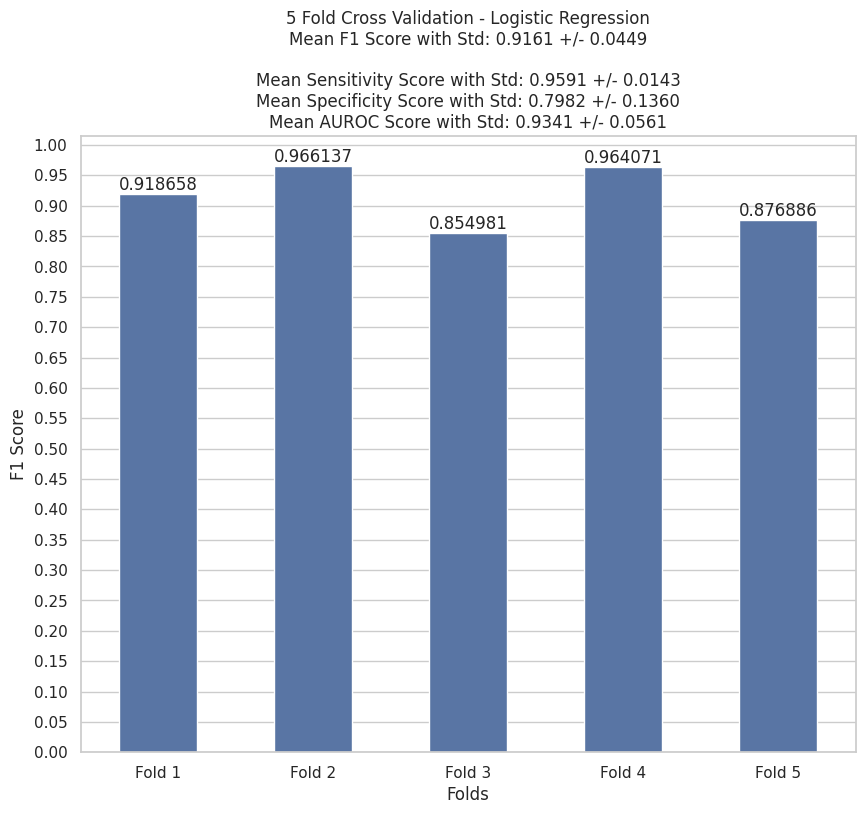

In [61]:
comp_fold_score_plot(lgc_cv_result, f"5 Fold Cross Validation - Logistic Regression\nMean F1 Score with Std: {np.mean(lgc_cv_result['test_f1_score_mean']):0.4f} +/- {np.std(lgc_cv_result['test_f1_score_mean']):0.4f}\n\nMean Sensitivity Score with Std: {np.mean(lgc_cv_result['test_sensitivity_mean']):0.4f} +/- {np.std(lgc_cv_result['test_sensitivity_mean']):0.4f}\nMean Specificity Score with Std: {np.mean(lgc_cv_result['test_specificity_mean']):0.4f} +/- {np.std(lgc_cv_result['test_specificity_mean']):0.4f}\nMean AUROC Score with Std: {np.mean(lgc_cv_result['test_auc_mean']):0.4f} +/- {np.std(lgc_cv_result['test_auc_mean']):0.4f}")

In [62]:
from sklearn.tree import DecisionTreeClassifier

dtc = DecisionTreeClassifier(criterion='entropy', max_depth=5, max_features='log2', min_samples_leaf=1, min_samples_split=6, class_weight='balanced', random_state=67)
dtc_cv_results = cross_validate(dtc, X_train, y_train, cv=5, return_estimator=True, return_train_score=True, scoring=bootstrap_scorer)

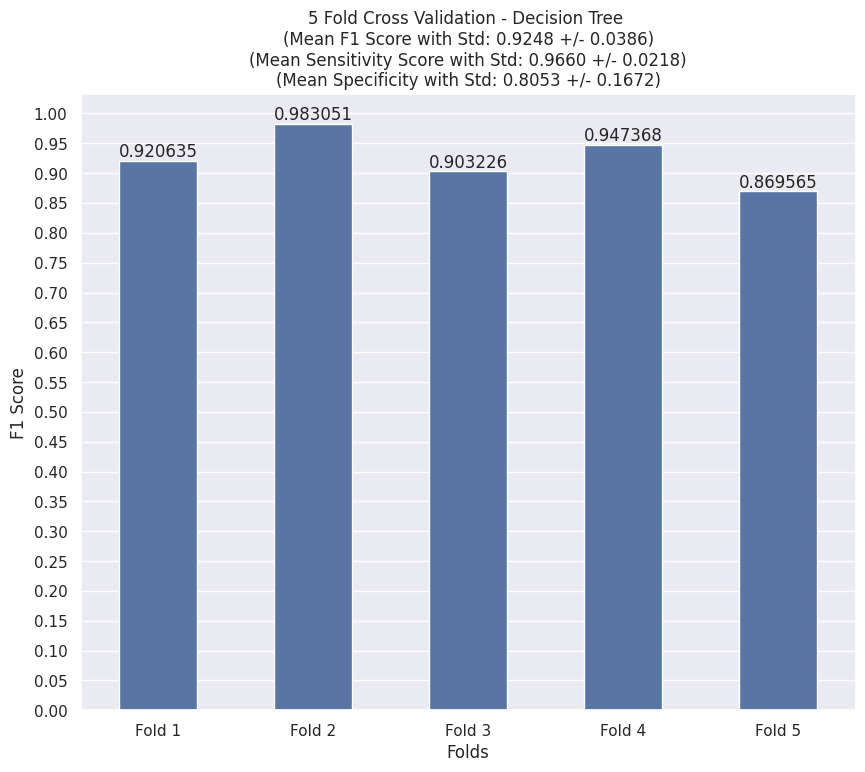

In [ ]:
comp_fold_score_plot(dtc_cv_results, f"5 Fold Cross Validation - Decision Tree\nMean F1 Score with Std: {np.mean(dtc_cv_results['test_f1_score_mean']):0.4f} +/- {np.std(dtc_cv_results['test_f1_score_mean']):0.4f}\n\nMean Sensitivity Score with Std: {np.mean(dtc_cv_results['test_sensitivity_mean']):0.4f} +/- {np.std(dtc_cv_results['test_sensitivity_mean']):0.4f}\nMean Specificity Score with Std: {np.mean(dtc_cv_results['test_specificity_mean']):0.4f} +/- {np.std(dtc_cv_results['test_specificity_mean']):0.4f}\nMean AUROC Score with Std: {np.mean(dtc_cv_results['test_auc_mean']):0.4f} +/- {np.std(dtc_cv_results['test_auc_mean']):0.4f}")

In [63]:
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV


sv_c = LinearSVC(C=1, penalty='l1', dual=False)
calibrated_svc = CalibratedClassifierCV(sv_c, method='sigmoid')
svc_cv_results = cross_validate(calibrated_svc, X_train, y_train, cv=5, return_estimator=True, return_train_score=True, scoring=bootstrap_scorer)

/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  w

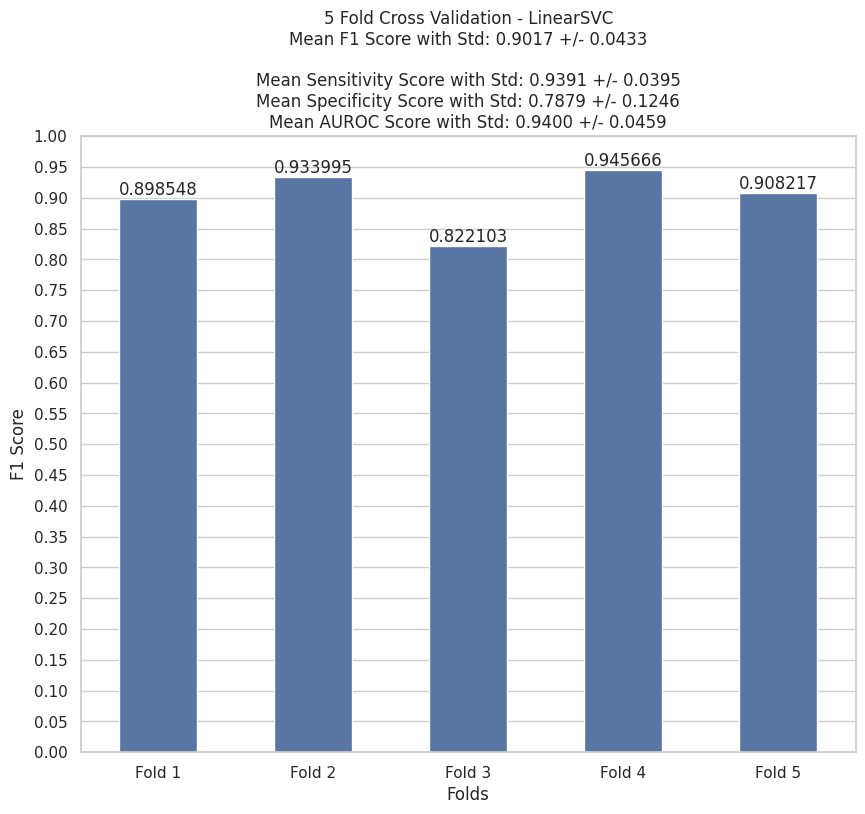

In [64]:
comp_fold_score_plot(svc_cv_results, f"5 Fold Cross Validation - LinearSVC\nMean F1 Score with Std: {np.mean(svc_cv_results['test_f1_score_mean']):0.4f} +/- {np.std(svc_cv_results['test_f1_score_mean']):0.4f}\n\nMean Sensitivity Score with Std: {np.mean(svc_cv_results['test_sensitivity_mean']):0.4f} +/- {np.std(svc_cv_results['test_sensitivity_mean']):0.4f}\nMean Specificity Score with Std: {np.mean(svc_cv_results['test_specificity_mean']):0.4f} +/- {np.std(svc_cv_results['test_specificity_mean']):0.4f}\nMean AUROC Score with Std: {np.mean(svc_cv_results['test_auc_mean']):0.4f} +/- {np.std(svc_cv_results['test_auc_mean']):0.4f}")

In [65]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(max_depth= 5, max_features = 'log2', min_samples_leaf= 1, min_samples_split= 5, n_estimators=100, class_weight='balanced')
rfc_cv_results = cross_validate(rfc, X_train, y_train, cv=5, return_estimator=True, return_train_score=True, scoring=bootstrap_scorer)

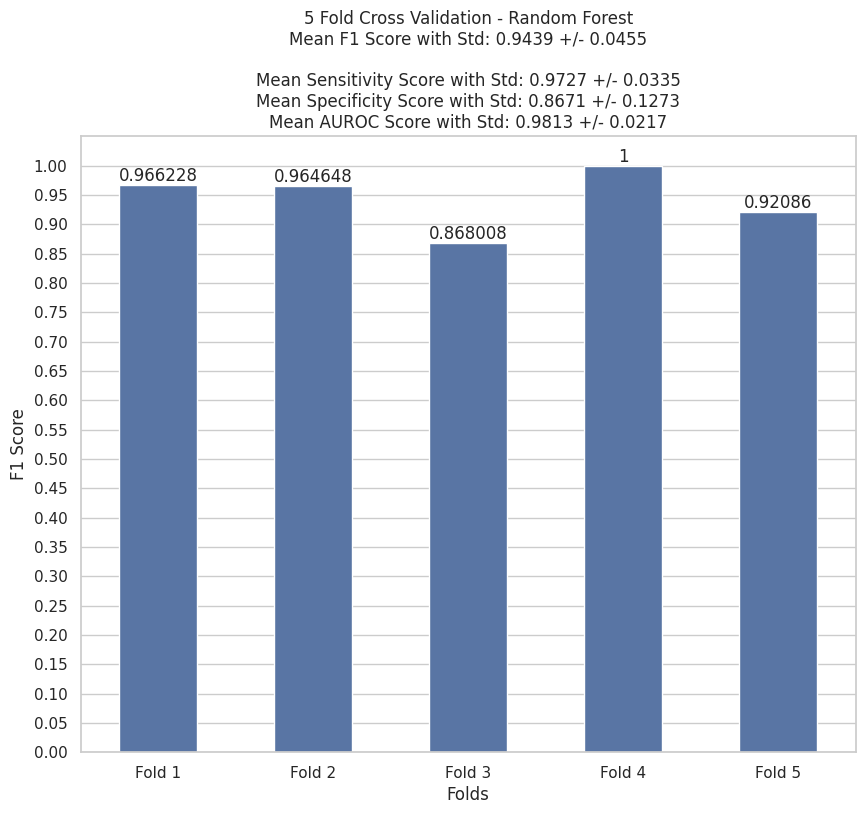

In [66]:
comp_fold_score_plot(rfc_cv_results, f"5 Fold Cross Validation - Random Forest\nMean F1 Score with Std: {np.mean(rfc_cv_results['test_f1_score_mean']):0.4f} +/- {np.std(rfc_cv_results['test_f1_score_mean']):0.4f}\n\nMean Sensitivity Score with Std: {np.mean(rfc_cv_results['test_sensitivity_mean']):0.4f} +/- {np.std(rfc_cv_results['test_sensitivity_mean']):0.4f}\nMean Specificity Score with Std: {np.mean(rfc_cv_results['test_specificity_mean']):0.4f} +/- {np.std(rfc_cv_results['test_specificity_mean']):0.4f}\nMean AUROC Score with Std: {np.mean(rfc_cv_results['test_auc_mean']):0.4f} +/- {np.std(rfc_cv_results['test_auc_mean']):0.4f}")

In [67]:
!pip install xgboost

In [68]:
from xgboost import XGBClassifier


xgb = XGBClassifier(n_estimators=200, objective='binary:logistic', gamma= 0.2, learning_rate= 0.01, max_depth=3, min_child_weight=1, reg_alpha=0, reg_lambda=0.1)
xgb_cv_results = cross_validate(xgb, X_train, y_train, cv=5, return_estimator=True, return_train_score=True, scoring=bootstrap_scorer)

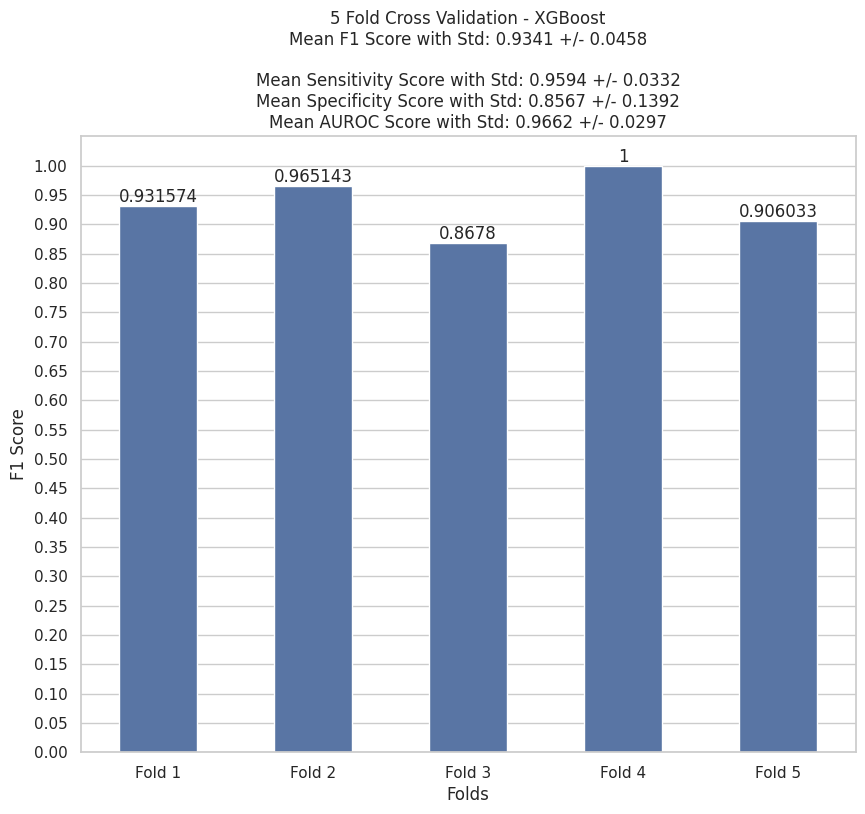

In [69]:
comp_fold_score_plot(xgb_cv_results, f"5 Fold Cross Validation - XGBoost\nMean F1 Score with Std: {np.mean(xgb_cv_results['test_f1_score_mean']):0.4f} +/- {np.std(xgb_cv_results['test_f1_score_mean']):0.4f}\n\nMean Sensitivity Score with Std: {np.mean(xgb_cv_results['test_sensitivity_mean']):0.4f} +/- {np.std(xgb_cv_results['test_sensitivity_mean']):0.4f}\nMean Specificity Score with Std: {np.mean(xgb_cv_results['test_specificity_mean']):0.4f} +/- {np.std(xgb_cv_results['test_specificity_mean']):0.4f}\nMean AUROC Score with Std: {np.mean(xgb_cv_results['test_auc_mean']):0.4f} +/- {np.std(xgb_cv_results['test_auc_mean']):0.4f}")

In [70]:
!pip install lightgbm

In [72]:
from lightgbm import LGBMClassifier


lgbm = LGBMClassifier(class_weight='balanced')
lgbm_cv_results = cross_validate(lgbm, X_train, y_train, cv=5, return_estimator=True, return_train_score=True, scoring=bootstrap_scorer)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 118, number of negative: 79
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001013 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3235
[LightGBM] [Info] Number of data points in the train set: 197, number of used features: 87
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

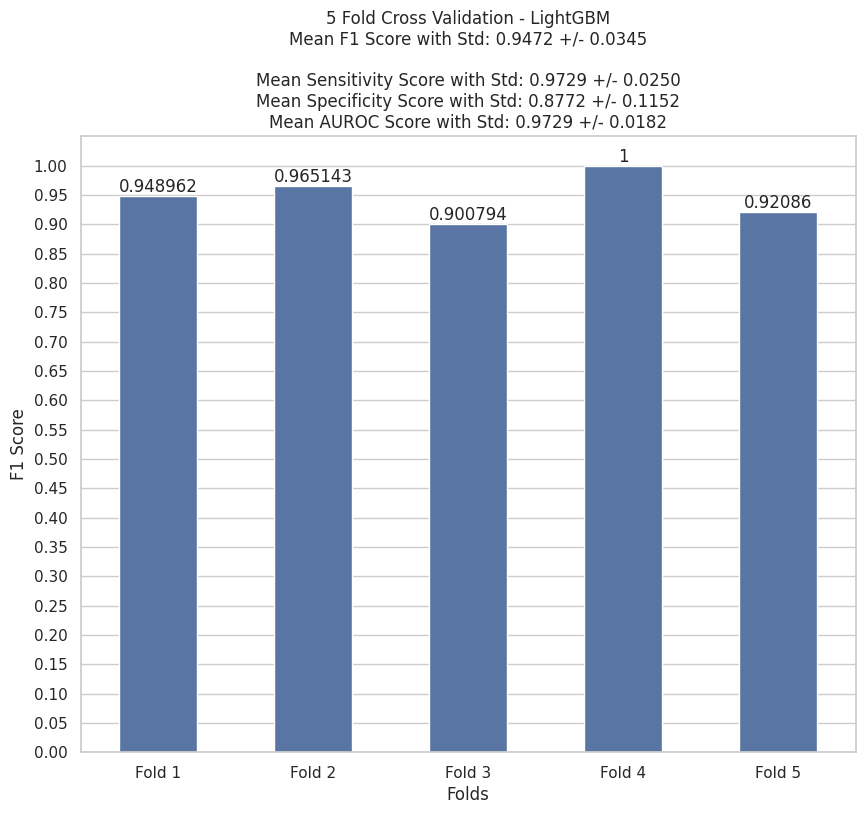

In [73]:
comp_fold_score_plot(lgbm_cv_results, f"5 Fold Cross Validation - LightGBM\nMean F1 Score with Std: {np.mean(lgbm_cv_results['test_f1_score_mean']):0.4f} +/- {np.std(lgbm_cv_results['test_f1_score_mean']):0.4f}\n\nMean Sensitivity Score with Std: {np.mean(lgbm_cv_results['test_sensitivity_mean']):0.4f} +/- {np.std(lgbm_cv_results['test_sensitivity_mean']):0.4f}\nMean Specificity Score with Std: {np.mean(lgbm_cv_results['test_specificity_mean']):0.4f} +/- {np.std(lgbm_cv_results['test_specificity_mean']):0.4f}\nMean AUROC Score with Std: {np.mean(lgbm_cv_results['test_auc_mean']):0.4f} +/- {np.std(lgbm_cv_results['test_auc_mean']):0.4f}")

In [74]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

algorithms = ["Logistic Regression", "Decision Tree", "LinearSVC", "Random Forest", "XGB Classifier", "LightGBM"]

mean_f1 = [
    np.mean(lgc_cv_result['test_f1_score_mean']),
    np.mean(dtc_cv_results['test_f1_score_mean']),
    np.mean(svc_cv_results['test_f1_score_mean']),
    np.mean(rfc_cv_results['test_f1_score_mean']),
    np.mean(xgb_cv_results['test_f1_score_mean']),
    np.mean(lgbm_cv_results['test_f1_score_mean'])
]

std_f1 = [
    np.std(lgc_cv_result['test_f1_score_mean']),
    np.std(dtc_cv_results['test_f1_score_mean']),
    np.std(svc_cv_results['test_f1_score_mean']),
    np.std(rfc_cv_results['test_f1_score_mean']),
    np.std(xgb_cv_results['test_f1_score_mean']),
    np.std(lgbm_cv_results['test_f1_score_mean'])
]

mean_auc = [
    np.mean(lgc_cv_result['test_auc_mean']),
    np.mean(dtc_cv_results['test_auc_mean']),
    np.mean(svc_cv_results['test_auc_mean']),
    np.mean(rfc_cv_results['test_auc_mean']),
    np.mean(xgb_cv_results['test_auc_mean']),
    np.mean(lgbm_cv_results['test_auc_mean'])
]

std_auc = [
    np.std(lgc_cv_result['test_auc_mean']),
    np.std(dtc_cv_results['test_auc_mean']),
    np.std(svc_cv_results['test_auc_mean']),
    np.std(rfc_cv_results['test_auc_mean']),
    np.std(xgb_cv_results['test_auc_mean']),
    np.std(lgbm_cv_results['test_auc_mean'])
]

# Step 2: Prepare long-format dataframe
df_f1 = pd.DataFrame({
    "Algorithms": algorithms,
    "Metric": "F1 Score",
    "Mean": mean_f1,
    "Std": std_f1
})

df_auc = pd.DataFrame({
    "Algorithms": algorithms,
    "Metric": "AUROC",
    "Mean": mean_auc,
    "Std": std_auc
})

metrics_df = pd.concat([df_f1, df_auc])
palette = ["#00a8ff", "#fbc531"]  # F1 Score and AUROC colors
sns.set(style="whitegrid")
plt.figure(figsize=(18, 6), dpi=1200)  # Increased width from 15 to 18
ax = sns.barplot(data=metrics_df, x="Mean", y="Algorithms", hue="Metric", palette=palette)

for i, row in metrics_df.iterrows():
    y_position = i % len(algorithms) + (0.2 if row['Metric'] == 'AUROC' else -0.2)
    ax.annotate(f"{row['Mean']:.4f} ± {row['Std']:.4f}",
                (row['Mean'], y_position),
                xytext=(6, 0), textcoords='offset points',
                ha='left', va='center', fontsize=8)

max_score = metrics_df['Mean'].max() + metrics_df['Std'].max()
plt.xlim(0, max_score + 0.05)
plt.xlabel("Score")
plt.ylabel("Algorithms")
plt.title("Comparison of Models: F1 Score vs AUROC")
plt.legend(title="Metric")
plt.tight_layout()
plt.show()

### **Testing Top Three Models on Heldout Test Data**
After evaluating all models through cross-validation, the top three performers—LightGBM, Random Forest, and XGBoost—were further assessed on a 30% held-out test set to examine their generalization capability. As shown in the figure above, LightGBM achieved the highest F1 Score `(0.9472 ± 0.0345)`, closely followed by Random Forest and XGBoost, both demonstrating strong performance across both F1 Score and AUROC.

All three models exhibited AUROC scores above `0.96`, confirming their ability to distinguish between Parkinson’s and non-Parkinson’s cases even on unseen data.

In [ ]:
rfc.fit(X_train, y_train)
bst.fit(X_train, y_train)
xgb.fit(X_train, y_train)

rfc_pred = rfc.predict(X_test)
bst_pred = bst.predict(X_test)
xgb_pred = xgb.predict(X_test)

rfc_pred_proba = rfc.predict_proba(X_test)
bst_pred_proba = bst.predict_proba(X_test)
xgb_pred_proba = xgb.predict_proba(X_test)

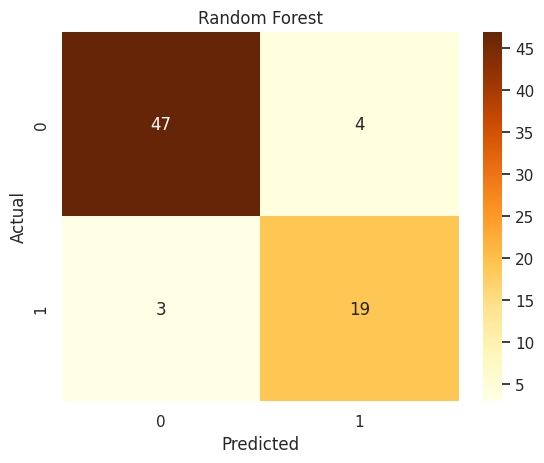

In [ ]:
sns.heatmap(confusion_matrix(rfc_pred, y_test), annot=True, fmt='d', cmap='YlOrBr')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Random Forest')
plt.show()

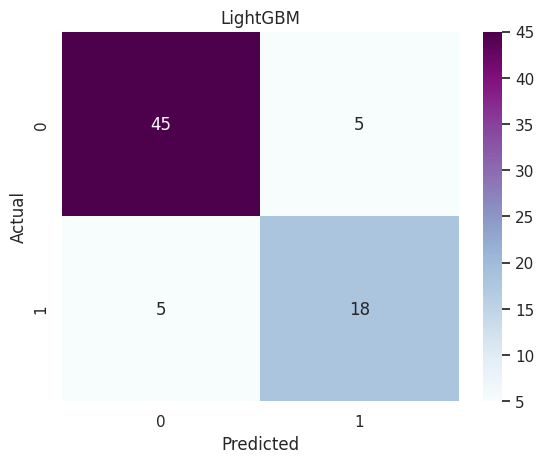

In [ ]:
sns.heatmap(confusion_matrix(bst_pred, y_test), annot=True, fmt='d', cmap="BuPu")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('LightGBM')
plt.show()

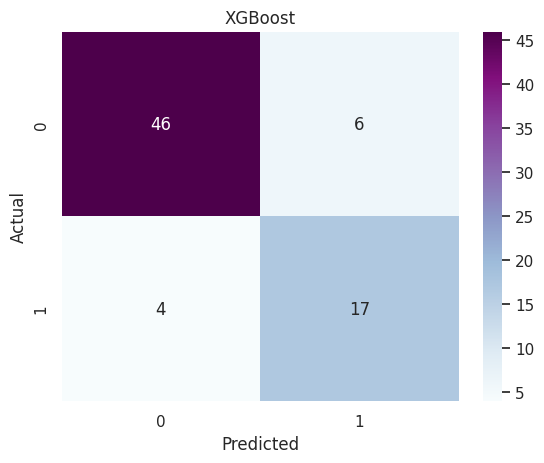

In [ ]:
sns.heatmap(confusion_matrix(xgb_pred, y_test), annot=True, fmt='d', cmap="BuPu")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('XGBoost')
plt.show()

In [ ]:
from IPython.display import Markdown

display(Markdown("## Random Forest Classifier"))
display(Markdown(f"**F1 Score:** {f1_score(rfc_pred, y_test):0.2f}"))
display(Markdown(f"**Sensitivity:** {recall_score(rfc_pred, y_test, pos_label=1):.2f}"))
display(Markdown(f"**Specificity:** {recall_score(rfc_pred, y_test, pos_label=0):.2f}"))

## Random Forest Classifier

**F1 Score:** 0.84

**Sensitivity:** 0.86

**Specificity:** 0.92

In [ ]:
from IPython.display import Markdown

display(Markdown("## LightGBM Classifier"))
display(Markdown(f"**F1 Score:** {f1_score(bst_pred, y_test):0.2f}"))
display(Markdown(f"**Sensitivity:** {recall_score(bst_pred, y_test, pos_label=1):.2f}"))
display(Markdown(f"**Specificity:** {recall_score(bst_pred, y_test, pos_label=0):.2f}"))

## LightGBM Classifier

**F1 Score:** 0.78

**Sensitivity:** 0.78

**Specificity:** 0.90

In [ ]:
from IPython.display import Markdown

display(Markdown("## XGBoost Classifier"))
display(Markdown(f"**F1 Score:** {f1_score(xgb_pred, y_test):0.2f}"))
display(Markdown(f"**Sensitivity:** {recall_score(xgb_pred, y_test, pos_label=1):.2f}"))
display(Markdown(f"**Specificity:** {recall_score(xgb_pred, y_test, pos_label=0):.2f}"))

## XGBoost Classifier

**F1 Score:** 0.77

**Sensitivity:** 0.81

**Specificity:** 0.88

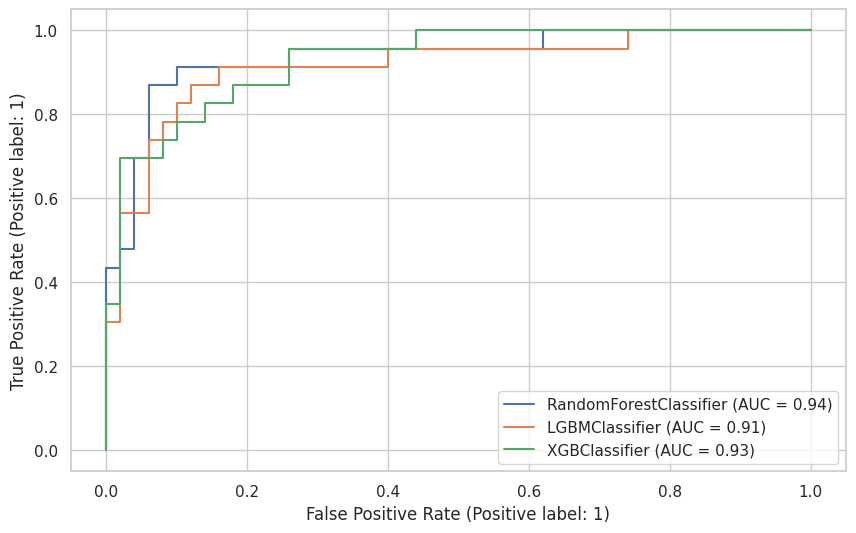

In [ ]:
from sklearn.metrics import RocCurveDisplay

fig, ax = plt.subplots(figsize=(10, 6))
RocCurveDisplay.from_estimator(rfc, X_test, y_test, ax=ax)
RocCurveDisplay.from_estimator(bst, X_test, y_test, ax=ax)
RocCurveDisplay.from_estimator(xgb, X_test, y_test, ax=ax)
plt.show()

### **Conclusion**

In this notebook, we evaluated the predictive power of various machine learning models trained on a processed dataset aimed at detecting Parkinson’s Disease. By employing 5-fold cross-validation with bootstrapping, we were able to obtain reliable estimates of model performance across multiple metrics.

Among the models tested, Random Forest, XGBoost, and LightGBM consistently delivered the highest F1 Scores and AUROC values, indicating their strong potential for classification in this context. The results from the held-out 30% test set further confirmed the generalizability of these models.

Overall, this analysis provides a valuable assessment of the dataset’s quality and its readiness for downstream machine learning tasks. The findings will guide future improvements in data collection and modeling as we move toward building a more robust diagnostic system.